## Train a CNN to Recognise Words

The stamp process in the '_Data' notebook has produced some nice-looking spectrograms with a uniform (64,32) shape. 

Let's just recognise the words the stamps represent by learning to differentiate between the 'stamp' images : a task for which the MNIST CNN is almost perfect for...

In [0]:
!pip install -qq tf-nightly-gpu-2.0-preview

     |████████████████████████████████| 378.7MB 83kB/s 
     |████████████████████████████████| 61kB 29.6MB/s 
     |████████████████████████████████| 4.1MB 41.8MB/s 
     |████████████████████████████████| 450kB 50.2MB/s 


In [0]:
"""Convolutional Neural Network Estimator, built with tf.keras (originally for MNIST)."""

import os, sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

import tensorflow as tf
from tensorflow import keras

do_training = True

In [0]:
print(sys.version)
print('Tensorflow:', tf.__version__)
print('Keras:', keras.__version__)

3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
Tensorflow: 2.0.0-dev20190724
Keras: 2.2.4-tf


Expecting:
```
3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
Tensorflow: 2.0.0-dev20190606
Keras: 2.2.4-tf
```

In [0]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [0]:
prefix='num'

In [0]:
# Load training and validation data
dataset = pickle.load(open(os.path.join('data', prefix+'.pkl'), 'rb'))

train_indices = [ i for i,r in enumerate(dataset['rand']) if r<=0.9 ]
check_indices = [ i for i,r in enumerate(dataset['rand']) if r>0.9 ]

print("Training and Validation(='check_') data loaded, %d items total " % (len(dataset['stamp']),))

Training and Validation(='check_') data loaded, 230 items total 


In [0]:
num_classes = 10

input_shape = (32, 64, 1)

batch_size = 20
num_epochs = 100   # Needs to be large-ish because of dropout below...

In [0]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(16, (5, 5), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(num_classes, activation='softmax'))

In [0]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

In [0]:
# Create Dataset iterator

def make_dataset(data, indices, seed=None, num_epochs=1, batch_size=batch_size):  
    # If seed is defined, this will shuffle data into batches

    # Get the data into tensorflow
    stamps = np.array( data['stamp'] )[indices]
    print("stamps.shape:", stamps.shape)
    # Ensure that the stamps are 'float32' in [0,1] and have the channel=1
    stamps_with_channel = np.expand_dims( stamps / 255.0, -1)

    labels = np.array( data['label'] )[indices]
    print("labels.shape:", labels.shape)
    labels_one_hot = keras.utils.to_categorical(labels, num_classes)

    all_images = tf.constant( stamps_with_channel, shape=stamps_with_channel.shape, dtype=tf.float32 )
    all_labels = tf.constant( labels_one_hot, shape=labels_one_hot.shape )  # , verify_shape=True
    
    ds = tf.data.Dataset.from_tensor_slices( (all_images, all_labels) )
    if seed is not None:
        ds = ds.shuffle(batch_size*4)
    
    ds = ds.repeat(num_epochs).batch(batch_size)
    
    return ds

In [0]:
ds_train = make_dataset(dataset, train_indices, num_epochs=num_epochs, seed=100)  # shuffles...
ds_check = make_dataset(dataset, check_indices, num_epochs=num_epochs, batch_size=1)

stamps.shape: (204, 32, 64)
labels.shape: (204,)
stamps.shape: (26, 32, 64)
labels.shape: (26,)


In [0]:
spe = len(train_indices) // batch_size
spe, len(train_indices)

(10, 204)

In [0]:
model.fit(ds_train, steps_per_epoch=spe, epochs=num_epochs, 
          validation_data=ds_check, validation_steps=len(check_indices), 
          verbose=1)

W0725 03:52:32.416753 140166315775872 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1251: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100


W0725 03:52:32.702716 140166315775872 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:468: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


10/10 [==============================] - 5s 457ms/step - loss: 2.3059 - accuracy: 0.0950 - val_loss: 2.3056 - val_accuracy: 0.0769
Epoch 2/100
10/10 [==============================] - 0s 11ms/step - loss: 2.3018 - accuracy: 0.0800 - val_loss: 2.3054 - val_accuracy: 0.1538
Epoch 3/100
10/10 [==============================] - 0s 12ms/step - loss: 2.2994 - accuracy: 0.1300 - val_loss: 2.3031 - val_accuracy: 0.2308
Epoch 4/100
10/10 [==============================] - 0s 11ms/step - loss: 2.2932 - accuracy: 0.1650 - val_loss: 2.3050 - val_accuracy: 0.1154
Epoch 5/100
10/10 [==============================] - 0s 11ms/step - loss: 2.2846 - accuracy: 0.1250 - val_loss: 2.2998 - val_accuracy: 0.0769
Epoch 6/100
10/10 [==============================] - 0s 11ms/step - loss: 2.2697 - accuracy: 0.1650 - val_loss: 2.2791 - val_accuracy: 0.2308
Epoch 7/100
10/10 [==============================] - 0s 11ms/step - loss: 2.2363 - accuracy: 0.1950 - val_loss: 2.2632 - val_accuracy: 0.1923
Epoch 8/100
10/10

In [0]:
score = model.evaluate(ds_check, steps=len(check_indices), verbose=1)
score

26/26 [==============================] - 0s 3ms/step - loss: 0.2117 - accuracy: 1.0000


[0.21166683177580126, 1.0]

... comment on results ...

### Now let's look at some 'live examples'

In [0]:
dataset_test = pickle.load(open(os.path.join('data', prefix+'-test.pkl'), 'rb'))

print("Ad-hoc test data loaded")

Ad-hoc test data loaded


In [0]:
def get_predictions_for_dataset( data ):
    n_points = len(data['stamp'])
    ds = make_dataset(data, range( n_points ), num_epochs=1, batch_size=1)

    pred_arr = model.predict(ds, steps=n_points, verbose=0)
    #print(pred_arr)  # This is an array of predictions, each with n_classes of probs

    predictions = [ dict(classes=i, probabilities=p, logits=np.log(p+1e-20)) 
                    for i, p in enumerate(pred_arr) ]
    
    for i, p in enumerate(predictions):
        label = int(data['label'][i])
        if label>=0:
            p['word'] = data['words'][label]
        else:
            p['word'] = data['words'][i]
        p['label'] = label
    
    return predictions

predictions = get_predictions_for_dataset(dataset_test)

print()
for i, prediction in enumerate(predictions):
    probs = ','.join([ "%6.2f%%" % (p*100,) for p in prediction['probabilities']] )
    print( "%s == %d  p=[%s]" % (dataset_test['words'][i], prediction['classes'],  probs,))

stamps.shape: (10, 32, 64)
labels.shape: (10,)

Martin-Digits_0 == 0  p=[ 97.06%,  0.00%,  1.14%,  0.00%,  1.75%,  0.00%,  0.00%,  0.01%,  0.00%,  0.03%]
Martin-Digits_1 == 1  p=[  0.12%, 72.03%,  3.12%,  0.02%,  0.05%,  4.70%,  0.01%,  0.96%,  0.01%, 19.00%]
Martin-Digits_2 == 2  p=[ 34.41%,  0.07%, 57.69%,  0.00%,  6.43%,  0.00%,  0.00%,  0.98%,  0.02%,  0.39%]
Martin-Digits_3 == 3  p=[  0.00%,  0.00%,  0.00%, 99.60%,  0.00%,  0.00%,  0.00%,  0.00%,  0.40%,  0.00%]
Martin-Digits_4 == 4  p=[  1.08%,  0.00%,  0.02%,  0.00%, 98.90%,  0.00%,  0.00%,  0.00%,  0.00%,  0.00%]
Martin-Digits_5 == 5  p=[  0.09%,  1.07%,  0.05%,  0.02%,  0.01%, 93.10%,  0.00%,  0.00%,  0.00%,  5.67%]
Martin-Digits_6 == 6  p=[  0.00%,  0.00%,  0.00%,  0.00%,  0.00%,  0.00%, 99.70%,  0.00%,  0.30%,  0.00%]
Martin-Digits_7 == 7  p=[  0.20%, 11.92%, 14.10%,  0.15%,  0.13%,  0.73%,  0.94%, 68.59%,  0.13%,  3.11%]
Martin-Digits_8 == 8  p=[  0.00%,  0.00%,  0.01%,  0.05%,  0.00%,  0.00%,  0.05%,  0.00%, 99.89%,  0.00%

In [0]:
def show_heat_map(heat_map, yticks=None):
    fig, ax = plt.subplots()
    ax.xaxis.tick_top()
    plt.imshow(heat_map, interpolation='nearest', cmap=plt.cm.Blues, aspect='auto')
    plt.xticks( range(10) )
    if yticks:
        plt.yticks( range(len(heat_map)), yticks )
    else:
        plt.yticks( range(len(heat_map)) )
    plt.show()

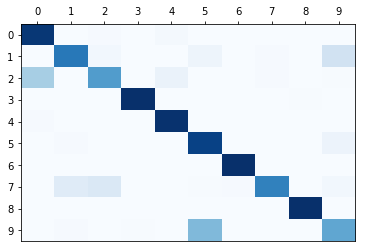

In [0]:
# And a heat map...
heat_map = [ prediction['probabilities'] for prediction in predictions]

show_heat_map(heat_map) 

### Extra... 

What happens if we try to look at the 'animals' test with the 'num' network?

stamps.shape: (20, 32, 64)
labels.shape: (20,)


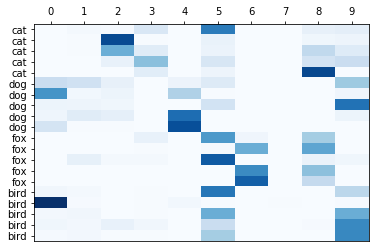

In [0]:
dataset_animals = pickle.load(open(os.path.join('data', 'animals.pkl'), 'rb'))

predictions_animals = get_predictions_for_dataset(dataset_animals)

heat_map = [ p['probabilities'] for p in predictions_animals]

show_heat_map(heat_map, [ p['word'] for p in predictions_animals])

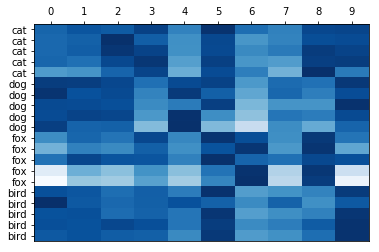

In [0]:
heat_map = [ p['logits'] for p in predictions_animals]
show_heat_map(heat_map, [ p['word'] for p in predictions_animals])

In [0]:
from sklearn import svm

animal_features, animal_targets=[],[]
for p in predictions_animals:
    #animal_features.append( p['probabilities'] )
    animal_features.append( p['logits'] )
    animal_targets.append( p['label'] )

animals_from_numbers_svm_classifier = svm.LinearSVC()
animals_from_numbers_svm_classifier.fit(animal_features, animal_targets) # learn from the data (QUICK!) 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [0]:
dataset_animals_test = pickle.load(open(os.path.join('data', 'animals-test.pkl'), 'rb'))

predictions_animals_test = get_predictions_for_dataset(dataset_animals_test)

print('\n\nanimals class predictions from SVM classifier based on digits-CNN output')
for i,p in enumerate(predictions_animals_test):
    #svm_prediction = animals_from_numbers_svm_classifier.predict( p['probabilities'].reshape(1,-1) )
    svm_prediction = animals_from_numbers_svm_classifier.predict( p['logits'].reshape(1,-1) )
    #decision     = animals_from_numbers_svm_classifier.decision_function([ np_logits[0] ])
    
    print("Sound[%d] is '%s' - predicted class[%d] = '%s'" % (
            i, dataset_animals['words'][i], 
            svm_prediction, dataset_animals['words'][svm_prediction[0]],))


stamps.shape: (4, 32, 64)
labels.shape: (4,)


animals class predictions from SVM classifier based on digits-CNN output
Sound[0] is 'cat' - predicted class[0] = 'cat'
Sound[1] is 'dog' - predicted class[1] = 'dog'
Sound[2] is 'fox' - predicted class[2] = 'fox'
Sound[3] is 'bird' - predicted class[3] = 'bird'


... Any good? ...